In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' # Keep using keras-2 (tf-keras) rather than keras-3 (keras).

import numpy as np
import matplotlib.pyplot as plt

from abc import abstractmethod
from typing import List

In [2]:
# Encode actions as integers:
EC = 0
EA = 1
DO_NOTHING = 2

NORMAL_STATE = 4

In [3]:
class WUREnvironment():

    def __init__(self, transition_model, p_aha, lambda_=0.01, p_aha_factor = 1.001):
        # Defining the number of states
        self._num_states = 6
        # Defining the number of actions
        self._num_actions = 2
        # Discount factor
        self._gamma = 0.99

        # Decaying factor for DO NOTHING action in transition matrix
        self._lambda = lambda_
        # By how much to increase the probability of AHA moment when the user gets it
        self._p_aha_factor = p_aha_factor

        # User specifications - transition matrix
        self._T = transition_model # shape = (num_actions, num_states, num_states); Dependent on the user -> given externally
        # User specifications - p_aha
        self._p_aha = p_aha
        
        self._current_state = NORMAL_STATE # the default (normal, normal) state
        self._step_count = 0

    # We model the fatigue factor as e^{-lambda}. It multiplies the probabilities of staying in the same state
    # when no action is taken.
    def _fatigue(self):
        return np.exp(-self._lambda)

    def _decay_transitions(self):
        for i in range(self._num_states):
            decay_update = self._T[DO_NOTHING][i, i] * self._fatigue()
            # assert decay_update > 0.5
            decay_update = min(decay_update, 0.5)
            self._T[DO_NOTHING][i, i] = decay_update

            mask = np.ones(self._num_states, dtype=bool)
            mask[i] = False
            normalization_factor = (1 - self._T[DO_NOTHING][i, i]) / np.sum(self._T[DO_NOTHING][i, mask])
            self._T[DO_NOTHING][i, mask] *= normalization_factor
            
        assert np.sum(self._T[DO_NOTHING], axis=1).all() == 1

    def step(self, action):
        """
        Takes an action and updates the current state of the environment.

        Parameters:
        - action (int): The action to be taken.
        Returns:
        - previous_state (int): The state before the update.
        """
        new_state = np.random.choice(np.arange(self._num_states), p=self._T[action][self._current_state])
        
        if action == EA:
            new_state = NORMAL_STATE if np.random.uniform() < self._p_aha[self._current_state] else new_state
            self._p_aha[self._current_state] *= self._p_aha_factor

        previous_state = self._current_state
        self._current_state = new_state
        
        self._decay_transitions()
        self._step_count += 1
        
        return previous_state

In [4]:
class EpsGreedyAgent:
    def __init__(self, env: WUREnvironment, explore_rate = 1.0):
        self._num_actions = env._num_actions
        self._num_states = env._num_states
        self._env = env

        # Initialization of Q and N
        self._Q = np.zeros(shape=(self._num_states, self._num_actions), dtype=float)
        self._N = np.zeros((self._num_states, self._num_actions), dtype=int)

        self._step_counts = 0
        self._explore = explore_rate  
        self._reward_history = []

    def argmax_with_random_tie_breaking(self, b):
        return np.random.choice(np.where(b == b.max())[0])

    def select_action(self, state):
        # Should be selected on the basis of epsilon greedy from the current state
        explore = np.random.binomial(2, p=self._explore)
        if explore:
            # Exploration: With probability epsilon take a random action, an index of an action
            a = np.random.choice(np.arange(self._num_actions))
        else:
            # Exploitation: With probability 1 - epsilon take one of the optimal actions for the current state
            a = self.argmax_with_random_tie_breaking(self._Q[state, :])
        return a

    @abstractmethod
    def update_estimates(self, action, reward, prev_state):
        pass
    
    def get_current_average_reward(self):
        return np.mean(self._reward_history)
    
    def get_cumulative_reward(self):
        return np.sum(self._reward_history)

In [5]:
class QEpsGreedyAgent(EpsGreedyAgent):
    def update_estimates(self, action, reward, prev_state):
        """
        Updates the Q-value estimates based on the given action, reward, and previous state.

        Parameters:
            - action (int): The action taken in the previous state.
            - reward (float): The reward received after taking the action.
            - prev_state (int): The previous state.
        """
        curr_state = self._env._current_state

        # Interaction with the environment - collecting reward 
        self._reward_history.append(reward)

        self._N[prev_state, action] += 1
        alpha = 0.5 / (self._N[prev_state, action] + 1) ** 0.75

        # Update Q according to the algorithm
        self._Q[prev_state, action] = \
            (1 - alpha) * self._Q[prev_state, action] + alpha * (reward + self._env._gamma*np.max(self._Q[curr_state, :]))        

        self._step_counts += 1
        return None

In [6]:
class SARSAEpsGreedyAgent(EpsGreedyAgent):
    def update_estimates(self, action, reward, prev_state):
        """
        Updates the Q-value estimates based on the given action, reward, and previous state.

        Parameters:
            - action (int): The action taken in the previous state.
            - reward (float): The reward received after taking the action.
            - prev_state (int): The previous state.
        Returns:
            - new_action (int): The new action to take in the current state.
        """
        curr_state = self._env._current_state

        # Interaction with the environment - collecting reward 
        self._reward_history.append(reward)

        self._N[prev_state, action] += 1
        alpha = 0.5 / (self._N[prev_state, action] + 1) ** 0.75

        # Sampling a new action
        new_action = self.select_action(curr_state)
        # Update Q according to the algorithm
        self._Q[prev_state, action] = (1 - alpha) * self._Q[prev_state, action] + alpha * (reward + self._env._gamma*self._Q[curr_state, new_action])

        self._step_counts += 1
        return new_action

In [7]:
class User:
    def __init__(self, base_transition_model, lambda_, p_aha, p_aha_factor, posture_change_factor):
        self._transition_model = self._initialize_transition_model(base_transition_model, posture_change_factor)
        self._lambda = lambda_
        self._p_aha = p_aha
        self._p_aha_factor = p_aha_factor
        self._posture_change_factor = posture_change_factor

    def _initialize_transition_model(self, base_transition_model, posture_change_factor):
        num_states = base_transition_model.shape[1]
        transition_model = base_transition_model.copy()

        # Modify the EA transition
        transition_model[EA] += np.random.normal(0, 0.05, size=(num_states, num_states))
        transition_model[EA] = np.abs(transition_model[EA])
        transition_model[EA] /= np.sum(transition_model[EA], axis=1)[:, np.newaxis]
        assert np.sum(transition_model[EA], axis=1).all() == 1
                                                                     
        # Modify the DO_NOTHING transition
        for i in range(num_states):
            transition_model[DO_NOTHING][i, i] *= posture_change_factor
            
            mask = np.ones(num_states, dtype=bool)
            mask[i] = False
            normalization_factor = (1 - transition_model[DO_NOTHING][i, i]) / np.sum(transition_model[DO_NOTHING][i, mask])
            transition_model[DO_NOTHING][i, mask] *= normalization_factor
        assert np.sum(transition_model[DO_NOTHING], axis=1).all() == 1
        
        return transition_model

    def Q_learning(self, num_iterations=500, max_delay=20, explore_rate=0.1):

        env = WUREnvironment(
            self._transition_model.copy(),
            self._p_aha.copy(),
            self._lambda,
            self._p_aha_factor
        )
        agent = QEpsGreedyAgent(env, explore_rate)
        
        average_rewards = []
        cum_rewards = []
        idxs = []

        counter = 0
        while True:
            if counter >= num_iterations:
                break

            state = env._current_state
            
            # If the current state is normal, let agent do nothing continue to the next iteration
            if state == NORMAL_STATE:
                env.step(action=DO_NOTHING)
                counter += 1
                continue

            # Else, select the corresponding action
            action = agent.select_action(state)
            reward = -1
            # Perform a step with the selected action until the current state is normal or the maximum delay is reached
            for idx in range(max_delay):
                env.step(action)
                if env._current_state == NORMAL_STATE:
                    reward = 1
                    break

            agent.update_estimates(action, reward, state)

            average_rewards.append(agent.get_current_average_reward())
            cum_rewards.append(agent.get_cumulative_reward())
            idxs.append(idx + 1)
            
            counter += idx + 1

        return agent._Q, env, average_rewards, cum_rewards, idxs

    def SARSA(self, num_iterations=500, max_delay=20, explore_rate=0.1):

        env = WUREnvironment(
            self._transition_model.copy(),
            self._p_aha.copy(),
            self._lambda,
            self._p_aha_factor
        )
        agent = SARSAEpsGreedyAgent(env, explore_rate)

        average_rewards = []
        cum_rewards = []
        idxs = []

        counter = 0 
        action = agent.select_action(env._current_state)
        while True:
            if counter >= num_iterations:
                break

            state = env._current_state
            
            # If the current state is normal, let agent do nothing continue to the next iteration
            if state == NORMAL_STATE:
                env.step(action=DO_NOTHING)
                counter += 1
                continue
            
            # Else, sellect the corresponding action
            reward = -1
            # Perform a step with the selected action until the current state is normal or the maximum delay is reached
            for idx in range(max_delay):
                env.step(action)                        
                if env._current_state == 4:
                    reward = 1
                    break
            
            action = agent.update_estimates(action, reward, state)  
            
            average_rewards.append(agent.get_current_average_reward())
            cum_rewards.append(agent.get_cumulative_reward())
            idxs.append(idx + 1)

            counter += idx + 1

        return agent._Q, env, average_rewards, cum_rewards, idxs

            
    def simulation(self, algorithm:str, num_iterations=500, explore_rate=1.0, max_delay=20):
        if algorithm == "Q":
            Q, env, average_rewards, cum_rewards, idxs = self.Q_learning(num_iterations, max_delay, explore_rate)
        elif algorithm == "SARSA":
            Q, env,average_rewards, cum_rewards, idxs = self.SARSA(num_iterations, max_delay, explore_rate)
        else:
            ValueError(f"Invalid algorithm '{algorithm}' chosen.")                 

        return Q, env, average_rewards, cum_rewards, idxs
    
    def optimal_actions(self, Q):
        actions = {0: "EC", 1: "EA", 2: "NOTHING"}
        optimal_action_idx = np.argmax(Q, axis=1)
        optimal_actions = np.array([actions[i] for i in optimal_action_idx])
        
        return np.array([optimal_actions[:3], optimal_actions[3:]])

In [8]:
def generate_users(base_transition_matrix, lambda_range, p_aha_range, p_aha_factor_range, posture_change_factor_range, num_users=10) -> List[User]:
    users = []
    for _ in range(num_users):
        lambda_ = np.random.uniform(*lambda_range)
        p_aha = np.random.uniform(*p_aha_range, size=6)
        p_aha_factor = np.random.uniform(*p_aha_factor_range)
        posture_change_factor = np.random.uniform(*posture_change_factor_range)

        user = User(base_transition_matrix, lambda_, p_aha, p_aha_factor, posture_change_factor)
        users.append(user)
    return users

## Base user parameters

In [9]:
# Simulating a user with a transition model

# Transitions for EC
ec_base = np.array([
    [0.4, 0.2, 0.05, 0.2, 0.1, 0.05],
    [0.025, 0.6, 0.025, 0.025, 0.3 ,0.025],
    [0.05, 0.2, 0.4, 0.05, 0.1, 0.2],
    [0.025, 0.025, 0.025, 0.6, 0.3, 0.025],
    [0.1, 0.1, 0.1, 0.1, 0.5, 0.1],
    [0.025, 0.025, 0.025, 0.025, 0.3, 0.6]
])

# Transitions for EA
ea_base = np.array([
    [0.9, 0.02, 0.02, 0.02, 0.02, 0.02],
    [0.02, 0.9, 0.02, 0.02, 0.02, 0.02],
    [0.02, 0.02, 0.9, 0.02, 0.02, 0.02],
    [0.02, 0.02, 0.02, 0.9, 0.02, 0.02],
    [0.02, 0.02, 0.02, 0.02, 0.9, 0.02],
    [0.02, 0.02, 0.02, 0.02, 0.02, 0.9]
])

# Transitions for DO NOTHING
do_nothing_base = np.array([
    [250, 15, 5, 15 ,5, 1],
    [15, 250, 15, 5, 15, 5],
    [5, 15, 250, 1, 5, 15],
    [15, 5, 1, 250, 15, 5],
    [5, 15, 5, 15, 250, 15],
    [1, 5, 15, 5, 15, 250],
])
do_nothing_base = do_nothing_base / np.sum(do_nothing_base, axis=1)[:, np.newaxis]

base_transition_matrix = np.array([ec_base, ea_base, do_nothing_base])

lambda_range = (1e-4, 0.00028) # The range for lambda in the fatigue factor
handness = (0, 1) # 0 - left handed, 1- right handed
p_aha_range = (0.1, 0.2) # The valid range of "AHA moment" probabilities
p_aha_factor_range = (1, 1.01) # The range for the factor by which the probability of AHA moment increases
posture_change_factor_range = (0.815, 1) # The range for the factor by which the probability of staying in the same state decreases


## Simulating a single user

In [10]:
user = generate_users(base_transition_matrix, lambda_range, p_aha_range, p_aha_factor_range, posture_change_factor_range, num_users=1)[0]
print(f"Lambda {user._lambda} | p_aha {user._p_aha} \np_aha_factor {user._p_aha_factor} | posture_change_factor {user._posture_change_factor}\n")

Lambda 0.0002526884024341139 | p_aha [0.10379783 0.1532945  0.1127768  0.16725593 0.13251634 0.17401915] 
p_aha_factor 1.005952298466051 | posture_change_factor 0.982928485296803



### Q-learning

In [11]:
# Q-learning
Q, env, average_rewards, cum_rewards, idxs = user.simulation("Q", num_iterations=1200, explore_rate=0.1, max_delay=7)

print("Q values:")
print(Q)
print()

print("Optimal_actions:")
print(user.optimal_actions(Q))
print()

Q values:
[[0.33495103 0.43298839]
 [0.69071006 0.84820883]
 [0.         0.74131772]
 [0.84321755 0.61765007]
 [0.         0.        ]
 [0.85744093 0.66602844]]

Optimal_actions:
[['EA' 'EA' 'EA']
 ['EC' 'EC' 'EC']]



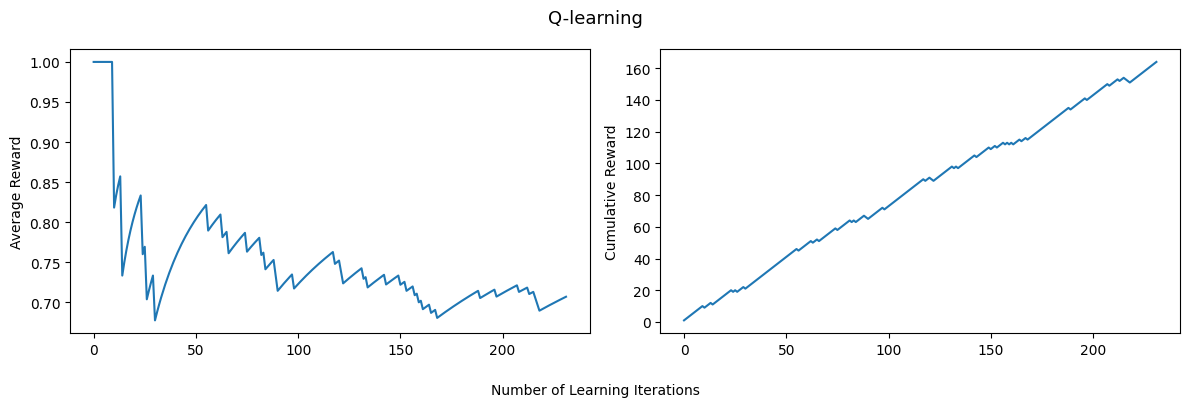

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot average_rewards
axs[0].plot(average_rewards)
axs[0].set_ylabel('Average Reward')

# Plot cum_rewards
axs[1].plot(cum_rewards)
axs[1].set_ylabel('Cumulative Reward')

fig.supxlabel('Number of Learning Iterations', fontsize=10)
fig.suptitle('Q-learning', fontsize=13)

plt.tight_layout()
plt.show()

### SARSA

In [13]:
# SARSA
Q, env, average_rewards, cum_rewards, idxs = user.simulation("SARSA", num_iterations=1200, explore_rate=0.1, max_delay=7)

print("Q values:")
print(Q)
print()

print("Optimal_actions:")
print(user.optimal_actions(Q))
print()

Q values:
[[0.73585647 0.58196188]
 [0.8267773  0.60720747]
 [0.57840406 0.55654774]
 [0.7970347  0.65268158]
 [0.         0.        ]
 [0.76149662 0.68378535]]

Optimal_actions:
[['EC' 'EC' 'EC']
 ['EC' 'EC' 'EC']]



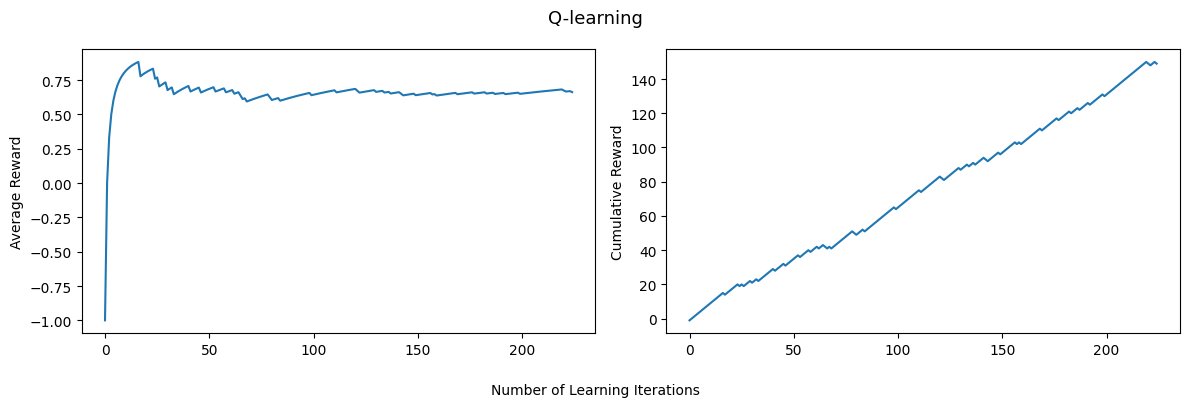

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot average_rewards
axs[0].plot(average_rewards)
axs[0].set_ylabel('Average Reward')

# Plot cum_rewards
axs[1].plot(cum_rewards)
axs[1].set_ylabel('Cumulative Reward')

fig.supxlabel('Number of Learning Iterations', fontsize=10)
fig.suptitle('Q-learning', fontsize=13)

plt.tight_layout()
plt.show()

## Simulating on multiple users

In [15]:
num_users = 10
users = generate_users(base_transition_matrix, lambda_range, p_aha_range, p_aha_factor_range, posture_change_factor_range, num_users=num_users)

### Q-learning

In [16]:
Qs = []
average_rewards = []
cum_rewards = []

for user in users:
    Q, env, avg_rewards, c_rewards, _ = user.simulation("Q", num_iterations=1200, explore_rate=0.1, max_delay=7)
    Qs.append(Q)
    average_rewards.append(avg_rewards)
    cum_rewards.append(c_rewards)

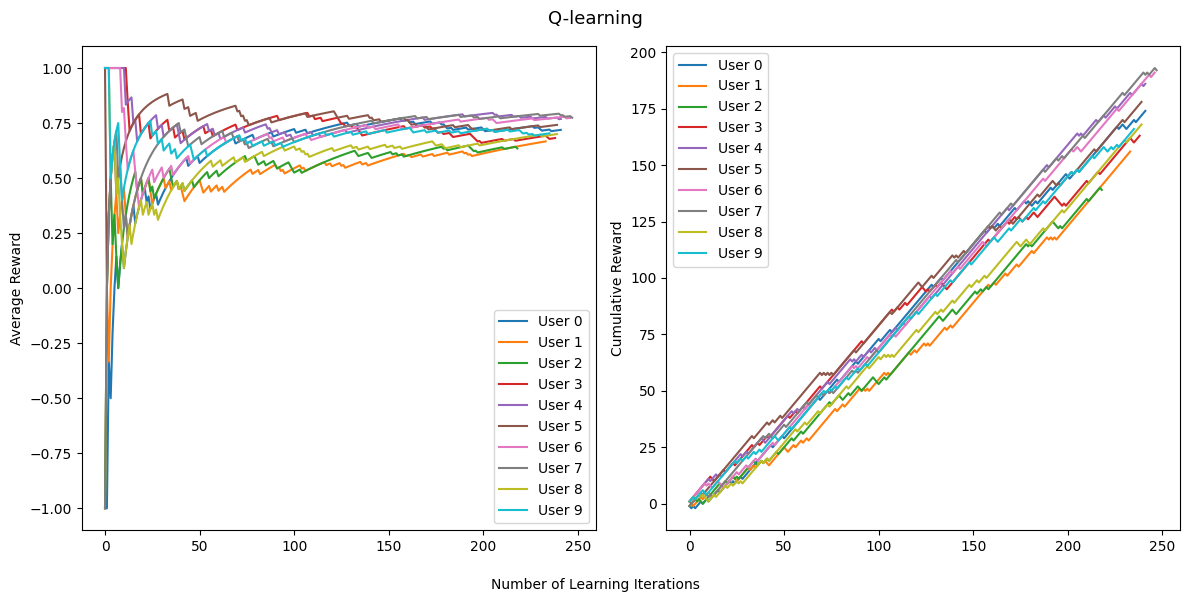

In [17]:
# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot average reward for each user
for idx in range(num_users):
    axs[0].plot(average_rewards[idx], label=f"User {idx}")
    axs[1].plot(cum_rewards[idx], label=f"User {idx}")

axs[0].set_ylabel("Average Reward")
axs[0].legend()

axs[1].set_ylabel("Cumulative Reward")
axs[1].legend()

fig.supxlabel('Number of Learning Iterations', fontsize=10)
fig.suptitle('Q-learning', fontsize=13)

plt.tight_layout()
plt.show()

### SARSA

In [18]:
Qs = []
average_rewards = []
cum_rewards = []

for user in users:
    Q, env, avg_rewards, c_rewards, _ = user.simulation("SARSA", num_iterations=1200, explore_rate=0.1, max_delay=7)
    Qs.append(Q)
    average_rewards.append(avg_rewards)
    cum_rewards.append(c_rewards)

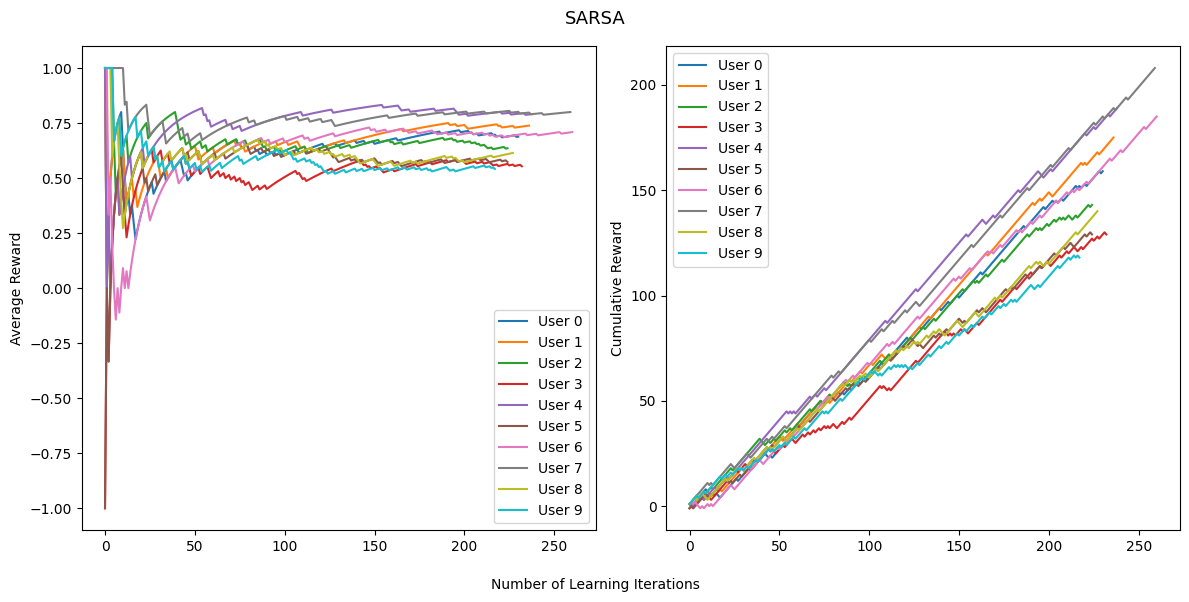

In [19]:
# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot average reward for each user
for idx in range(num_users):
    axs[0].plot(average_rewards[idx], label=f"User {idx}")
    axs[1].plot(cum_rewards[idx], label=f"User {idx}")

axs[0].set_ylabel("Average Reward")
axs[0].legend()

axs[1].set_ylabel("Cumulative Reward")
axs[1].legend()

fig.supxlabel('Number of Learning Iterations', fontsize=10)
fig.suptitle('SARSA', fontsize=13)

plt.tight_layout()
plt.show()